# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 6946 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Found 1734 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Validation Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Test Class Labels: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


Image dimensions: (128, 128, 3)


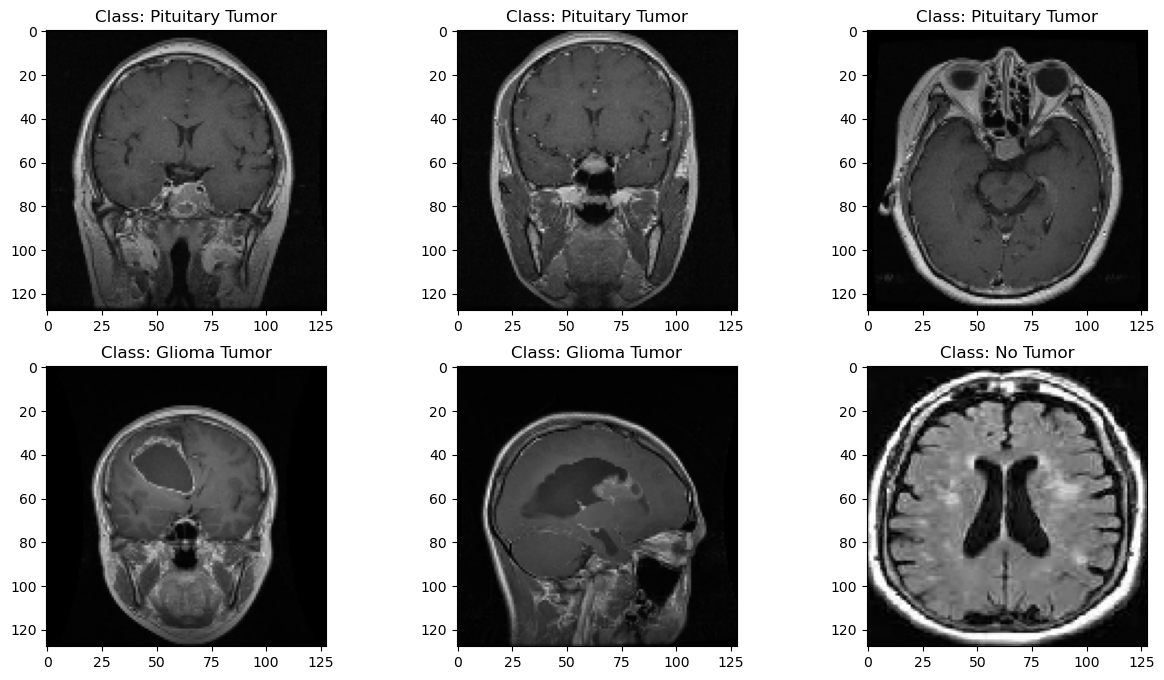

In [6]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'Glioma Tumor': 0, 'Meningioma Tumor': 1, 'No Tumor': 2, 'Pituitary Tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [9]:
# Extract data and labels from the generated batches on train set
data_train, labels_train = [], []
for _ in range(len(train_gen)):
    images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
    data_train.extend(images_train)
    labels_train.extend(batch_labels_train)

# Extract data and labels from the generated batches on test set
data_test, labels_test = [], []
for _ in range(len(test_gen)):
    images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
    data_test.extend(images_train)
    labels_test.extend(batch_labels_test)

# Extract data and labels from the generated batches on validation set
data_val, labels_val = [], []
for _ in range(len(val_gen)):
    images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
    data_val.extend(images_val)
    labels_val.extend(batch_labels_val)

# Flatten the image data
data_train_flat = np.array(data_train).reshape(len(data_train), -1)
data_test_flat = np.array(data_test).reshape(len(data_test), -1)
data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# Create Dataframes for each set. Keep class labels in order
df_train_data = pd.DataFrame(data_train_flat)
df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_train = pd.concat([df_train_data, df_train_labels], axis=1)

df_test_data = pd.DataFrame(data_test_flat)
df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_test = pd.concat([df_test_data, df_test_labels], axis=1)

df_val_data = pd.DataFrame(data_val_flat)
df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [10]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,49146,49147,49148,49149,49150,49151,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
4,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,...,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.0,0.0,1.0,0.0


In [11]:
# Display the shape of each DataFrame
print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
print("Validation DataFrame shape:", df_val.shape)

Train DataFrame shape: (6946, 49156)
Test DataFrame shape: (1728, 49156)
Validation DataFrame shape: (1734, 49156)


Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Principal Component Analysis

In [12]:
from sklearn.decomposition import PCA

# Convert column names to strings
df_train.columns = df_train.columns.astype(str)
df_test.columns = df_test.columns.astype(str)
df_val.columns = df_val.columns.astype(str)

columns_drop = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

train_pca = df_train.drop(columns=columns_drop)
test_pca = df_test.drop(columns=columns_drop)
val_pca = df_val.drop(columns=columns_drop)

In [13]:
# Define variance to retain
variance = 0.95

# Instatiate PCA 
pca = PCA(variance)

# fit the PCA on train data
pca.fit(train_pca)

PCA(n_components=0.95)

In [14]:
# Transform the data
pca_data_train = pca.transform(train_pca)
pca_data_test = pca.transform(test_pca)
pca_data_val = pca.transform(val_pca)

In [15]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_labels = df_train[labels]
test_labels = df_test[labels]
val_labels = df_val[labels]

# SVM

In [16]:
# Convert one-hot encoded labels to integer labels
integer_train_labels = np.argmax(train_labels, axis=1)
integer_test_labels = np.argmax(test_labels, axis=1)

In [17]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X=pca_data_train, y=integer_train_labels)

SVC()

In [18]:
clf.score(X=pca_data_test, y=integer_test_labels)

0.2465277777777778

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(pca_data_test)
cm = confusion_matrix(integer_test_labels, y_pred, labels=range(len(labels)))

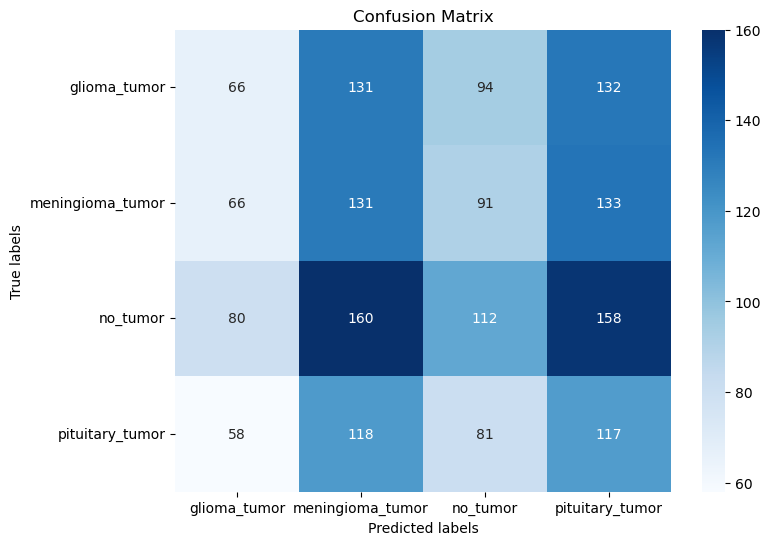

In [22]:
import seaborn as sns
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], yticklabels=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Convolutinal Base

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8388736   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,389,700
Trainable params: 8,389,700
Non-trainable params: 0
______________________________________________

Epoch 1/50
218/218 [==============================] - 19s 57ms/step - loss: 0.6012 - precision: 0.8301 - recall: 0.6922 - accuracy: 0.7695 - val_loss: 0.2382 - val_precision: 0.9276 - val_recall: 0.9020 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 36ms/step - loss: 0.1484 - precision: 0.9497 - recall: 0.9428 - accuracy: 0.9462 - val_loss: 0.1550 - val_precision: 0.9518 - val_recall: 0.9446 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0507 - precision: 0.9873 - recall: 0.9865 - accuracy: 0.9870 - val_loss: 0.1213 - val_precision: 0.9578 - val_recall: 0.9544 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0186 - precision: 0.9967 - recall: 0.9965 - accuracy: 0.9965 - val_loss: 0.1275 - val_precision: 0.9526 - val_recall: 0.9504 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 5/50
218/218 [===========================

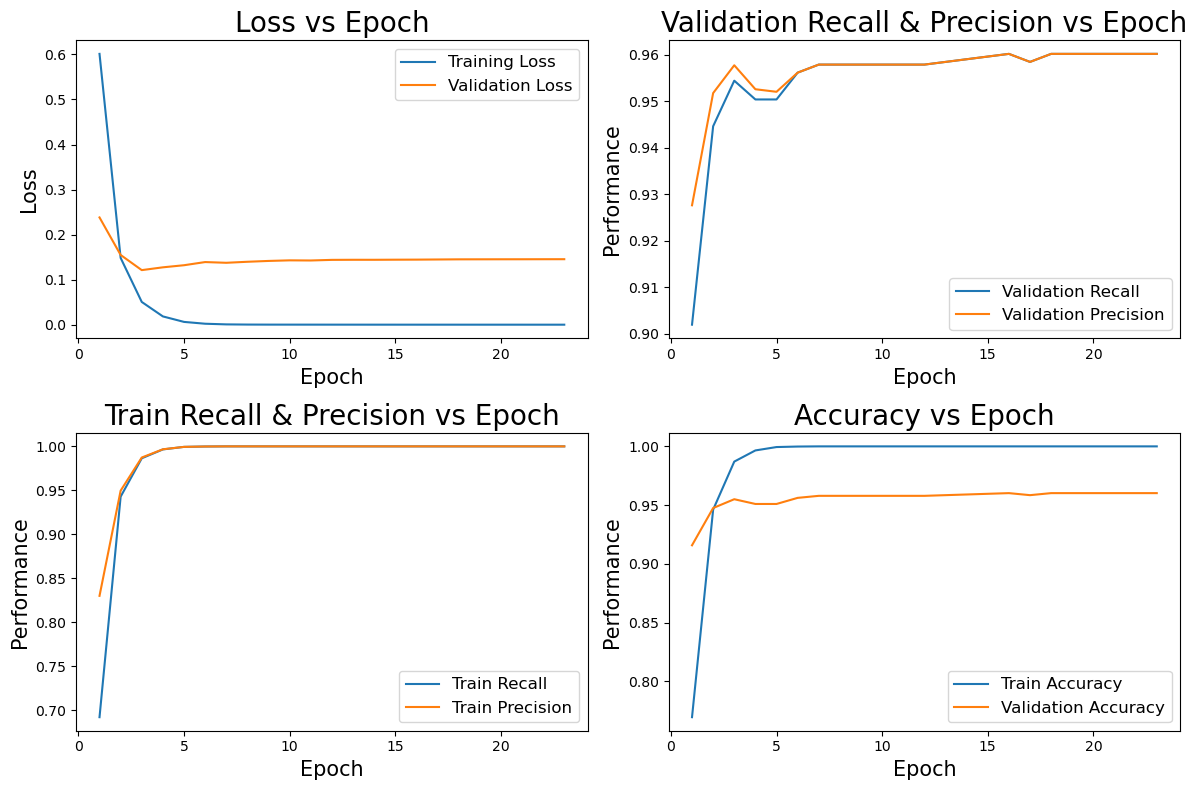

In [10]:
from functions import view_history, train_model, model_evaluate

# Define dictionary to store history
conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version1')

In [11]:
# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

 3/54 [>.............................] - ETA: 2s - loss: 0.0212 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1213 - precision: 0.9578 - recall: 0.9544 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.020206,99.798447,99.798447,99.798447
1,Test,0.625764,91.230136,90.909094,90.909094
2,Validation,0.121322,95.775461,95.444059,95.501733


It seems that our might be overfitting or another possibility is that we arent capturing enough of the data complexity. We plateau pretty fast for val_loss but for train_loss the curve seems a little underdeveloped.

**Next Steps**: Increase model complexity to confirm overfit.

# CNN Version 2

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(256, activation='relu'))
cnn2.add(Dense(256, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               67109120  
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                      

Epoch 1/50
218/218 [==============================] - 21s 61ms/step - loss: 0.7045 - precision: 0.8104 - recall: 0.6912 - accuracy: 0.7597 - val_loss: 0.2369 - val_precision: 0.9167 - val_recall: 0.9014 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 39ms/step - loss: 0.1251 - precision: 0.9568 - recall: 0.9541 - accuracy: 0.9552 - val_loss: 0.1499 - val_precision: 0.9478 - val_recall: 0.9418 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0517 - precision: 0.9829 - recall: 0.9820 - accuracy: 0.9824 - val_loss: 0.2015 - val_precision: 0.9243 - val_recall: 0.9152 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.0343 - precision: 0.9902 - recall: 0.9888 - accuracy: 0.9892 - val_loss: 0.1466 - val_precision: 0.9509 - val_recall: 0.9498 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 5/50
218/218 [===========================

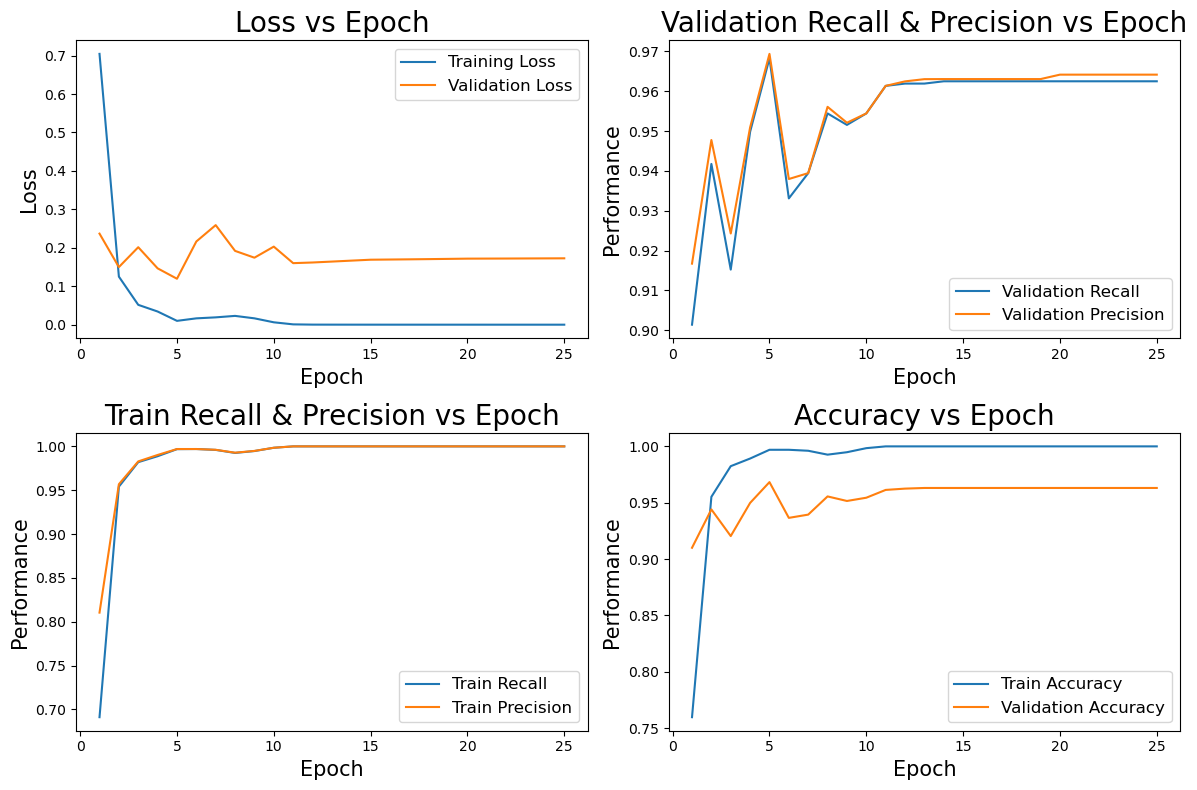

 2/54 [>.............................] - ETA: 3s - loss: 0.0053 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1195 - precision: 0.9694 - recall: 0.9683 - accuracy: 0.9683


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.002623,99.942410,99.942410,99.942410
1,Test,1.011205,90.845072,90.791792,90.791792
2,Validation,0.119542,96.939951,96.828145,96.828145


In [10]:
from functions import train_model, model_evaluate, view_history
conv = {}
# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

Increasing the complexity of the Convolutional layer caused us to overfit. This is also true for increasing neurons.

**Next Steps**: keep the same complexity from the base as our train curve is better but introduce regularization

# CNN Version 4

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn4 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn4.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn4.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn4.add(Flatten())
cnn4.add(Dense(64, activation='relu'))

# Define the output 
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                4194368   
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,195,076
Trainable params: 4,195,076
Non-trainable params: 0
____________________________________________

Epoch 1/50
218/218 [==============================] - 9s 39ms/step - loss: 0.5261 - precision: 0.8742 - recall: 0.7933 - accuracy: 0.8009 - val_loss: 0.2583 - val_precision: 0.9218 - val_recall: 0.8979 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1547 - precision: 0.9486 - recall: 0.9414 - accuracy: 0.9456 - val_loss: 0.1695 - val_precision: 0.9437 - val_recall: 0.9377 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0544 - precision: 0.9857 - recall: 0.9849 - accuracy: 0.9853 - val_loss: 0.1433 - val_precision: 0.9518 - val_recall: 0.9458 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0219 - precision: 0.9961 - recall: 0.9957 - accuracy: 0.9958 - val_loss: 0.1161 - val_precision: 0.9589 - val_recall: 0.9562 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/50
218/218 [============================

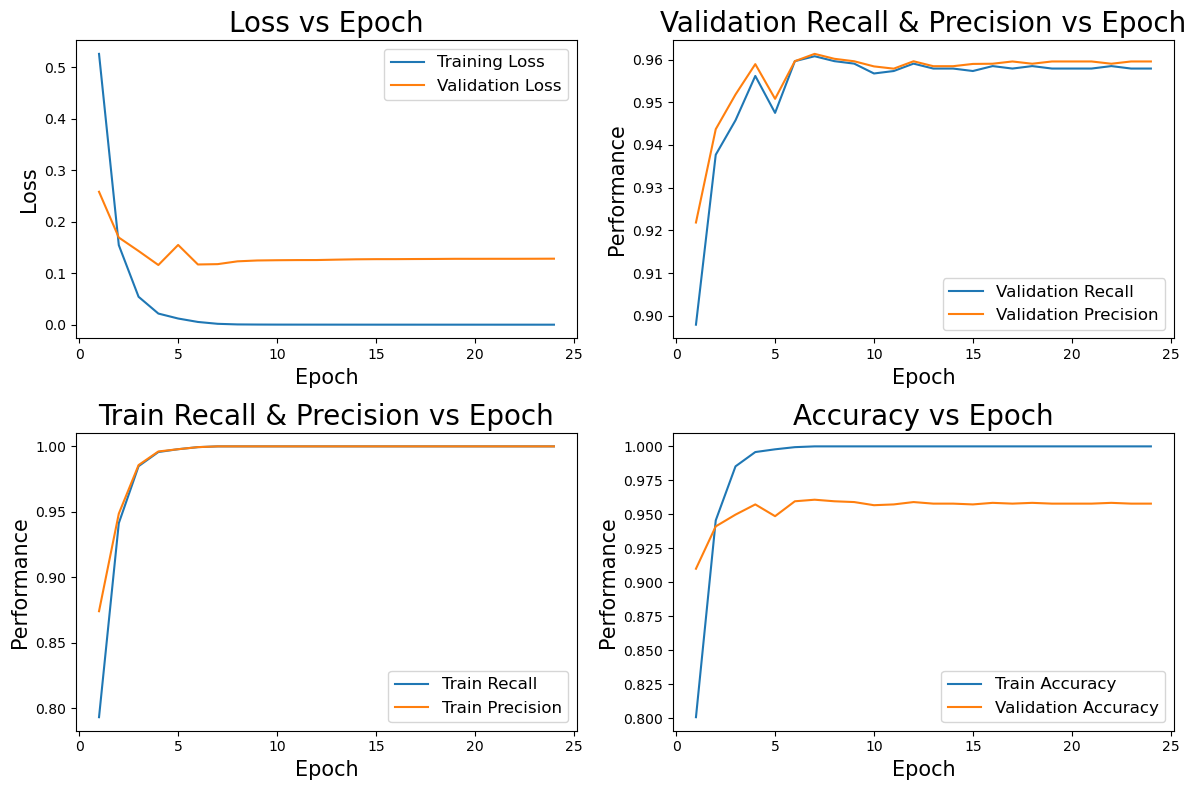

 3/54 [>.............................] - ETA: 1s - loss: 0.0238 - precision: 0.9896 - recall: 0.9896 - accuracy: 0.9896

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.1161 - precision: 0.9589 - recall: 0.9562 - accuracy: 0.9573


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.011207,99.899220,99.899220,99.899220
1,Test,0.675303,90.786386,90.733141,90.791792
2,Validation,0.116127,95.893580,95.617068,95.732409


In [13]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version4'] = train_model(cnn4, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version4')

# Evalaute model
model_evaluate(cnn4, train_gen, test_gen, val_gen)

Reducing model complexity didnt help. We perform about the same. Our losses are about the same. We need to introduce regualrization and we need to introduce more convolutional layers.

**Next Steps**: Introduce regularization and introduce another Convolutinal layer to attempt gaining more information.

# CNN Version 5

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn5 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn5.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))
cnn5.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn5.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn5.add(Flatten())
cnn5.add(Dense(256, activation='relu'))
cnn5.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn5.add(Dense(4, activation='softmax'))

cnn5.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 256)              

Epoch 1/50
218/218 [==============================] - 9s 39ms/step - loss: 1.3157 - precision: 0.8449 - recall: 0.7408 - accuracy: 0.7524 - val_loss: 0.5859 - val_precision: 0.8804 - val_recall: 0.8489 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4030 - precision: 0.9147 - recall: 0.9002 - accuracy: 0.9064 - val_loss: 0.3126 - val_precision: 0.9311 - val_recall: 0.9273 - val_accuracy: 0.9285 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 37ms/step - loss: 0.1900 - precision: 0.9623 - recall: 0.9593 - accuracy: 0.9606 - val_loss: 0.2002 - val_precision: 0.9526 - val_recall: 0.9504 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 37ms/step - loss: 0.0996 - precision: 0.9824 - recall: 0.9811 - accuracy: 0.9820 - val_loss: 0.1878 - val_precision: 0.9572 - val_recall: 0.9544 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 5/50
218/218 [============================

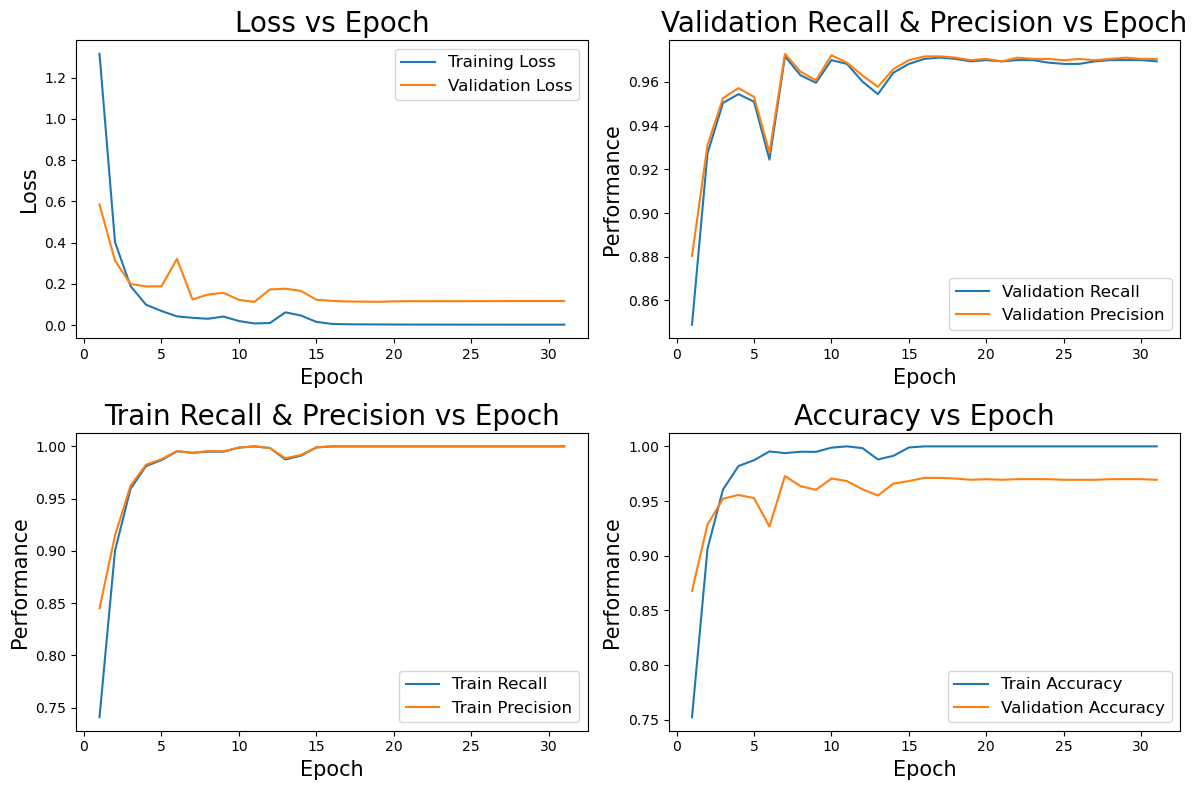

 3/54 [>.............................] - ETA: 1s - loss: 0.0120 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 29ms/step - loss: 0.1130 - precision: 0.9688 - recall: 0.9683 - accuracy: 0.9683


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.007784,100.000000,100.000000,100.000000
1,Test,0.758421,91.260999,91.260999,91.260999
2,Validation,0.112969,96.884018,96.828145,96.828145


In [15]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version5'] = train_model(cnn5, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version5')

# Evalaute model
model_evaluate(cnn5, train_gen, test_gen, val_gen)

The model is performing better. We should add more regularization now. 

**Next Steps**: Add a Dropout layer.

# CNN Version 6

In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn6 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Dropout(.20))

# Flatten Tensor
cnn6.add(Flatten())
cnn6.add(Dense(256, activation='relu'))
cnn6.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn6.add(Dense(4, activation='softmax'))

cnn6.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 32768)            

Epoch 1/50
218/218 [==============================] - 9s 38ms/step - loss: 1.4927 - precision: 0.8347 - recall: 0.7062 - accuracy: 0.7282 - val_loss: 0.7238 - val_precision: 0.8477 - val_recall: 0.8281 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4850 - precision: 0.9012 - recall: 0.8824 - accuracy: 0.8939 - val_loss: 0.3590 - val_precision: 0.9243 - val_recall: 0.9158 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 8s 38ms/step - loss: 0.2575 - precision: 0.9445 - recall: 0.9385 - accuracy: 0.9415 - val_loss: 0.2480 - val_precision: 0.9432 - val_recall: 0.9389 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 8s 38ms/step - loss: 0.1322 - precision: 0.9746 - recall: 0.9726 - accuracy: 0.9738 - val_loss: 0.1939 - val_precision: 0.9543 - val_recall: 0.9510 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 5/50
218/218 [============================

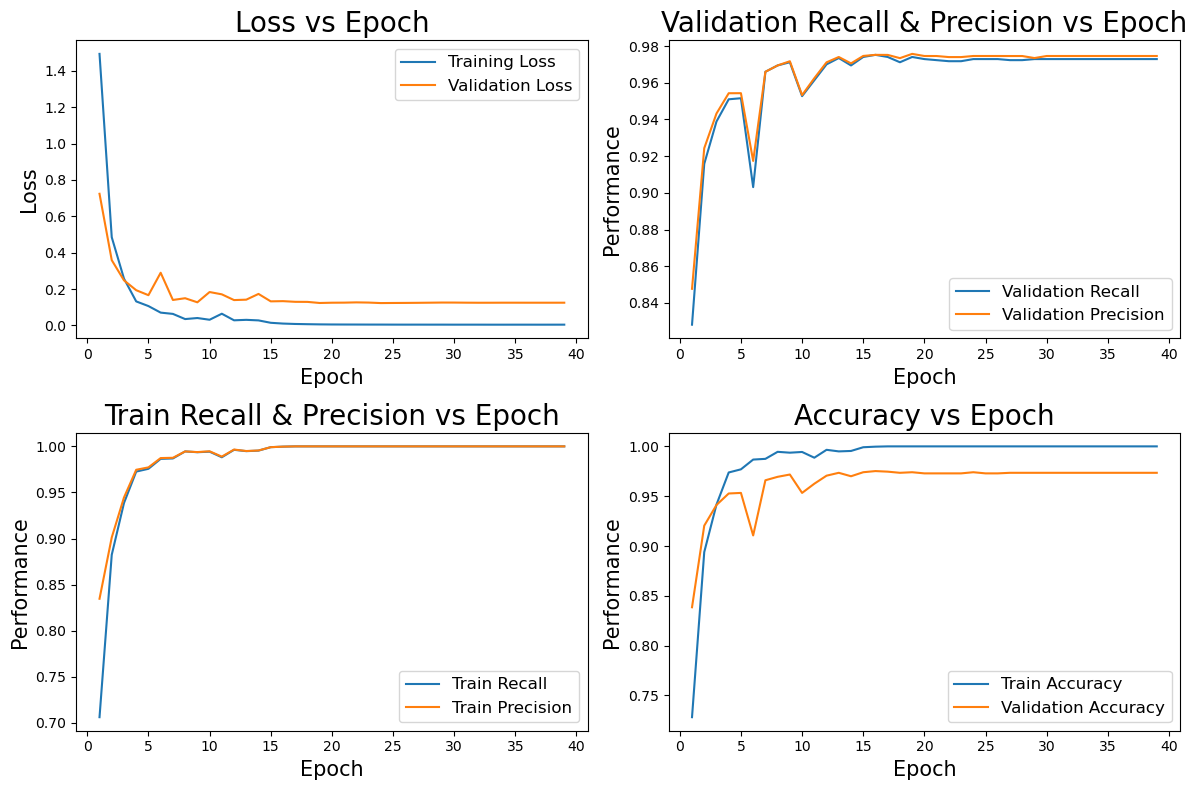

 3/54 [>.............................] - ETA: 1s - loss: 0.0053 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


55/55 [==============================] - 2s 30ms/step - loss: 0.1236 - precision: 0.9757 - recall: 0.9740 - accuracy: 0.9740


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.005221,100.000000,100.000000,100.000000
1,Test,0.781417,92.230725,91.906160,92.082113
2,Validation,0.123611,97.573656,97.404844,97.404844


In [17]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version6'] = train_model(cnn6, train_gen, val_gen, 50)

# View history 
view_history(conv, 'Version6')

# Evalaute model
model_evaluate(cnn6, train_gen, test_gen, val_gen)

Adding Dropout before the Dense Layers helped reduce overfit. What we can now is introduce more regularization in hopes to improve val loss and generalization.

**Next Steps:** Increase regularization on drpout.

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn6 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
cnn6.add(MaxPool2D(pool_size=(2,2)))
cnn6.add(Dropout(.20))

# Flatten Tensor
cnn6.add(Flatten())
cnn6.add(Dense(256, activation='relu'))
cnn6.add(Dense(256, activation='relu', kernel_regularizer=l2()))

# Define the output 
cnn6.add(Dense(4, activation='softmax'))

cnn6.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn6.summary())

# CNN Version 3

Lets implement a model framework from a [publication](https://ieeexplore.ieee.org/document/8723045).

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn3 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn3.add(Conv2D(filters=64, kernel_size=(10, 10), strides=(1,1), activation='relu', padding='same', input_shape=input_shape))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Dropout(.2))
cnn3.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Dropout(.2))

# Flatten Tensor and create Fully conected layer
cnn3.add(Flatten())
cnn3.add(Dense(256, activation='relu'))

# Define the output layer 
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      19264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)      

Epoch 1/100
72/72 [==============================] - 5s 51ms/step - loss: 1.0752 - precision: 0.7090 - recall: 0.4314 - accuracy: 0.5276 - val_loss: 0.8497 - val_precision: 0.7409 - val_recall: 0.4991 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 3s 40ms/step - loss: 0.7307 - precision: 0.7360 - recall: 0.6286 - accuracy: 0.6944 - val_loss: 0.6602 - val_precision: 0.7510 - val_recall: 0.6736 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 3s 41ms/step - loss: 0.5390 - precision: 0.7971 - recall: 0.7458 - accuracy: 0.7741 - val_loss: 0.6049 - val_precision: 0.7934 - val_recall: 0.7504 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 3s 41ms/step - loss: 0.3930 - precision: 0.8609 - recall: 0.8324 - accuracy: 0.8468 - val_loss: 0.4389 - val_precision: 0.8520 - val_recall: 0.8237 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 5/100
72/72 [==============================] -

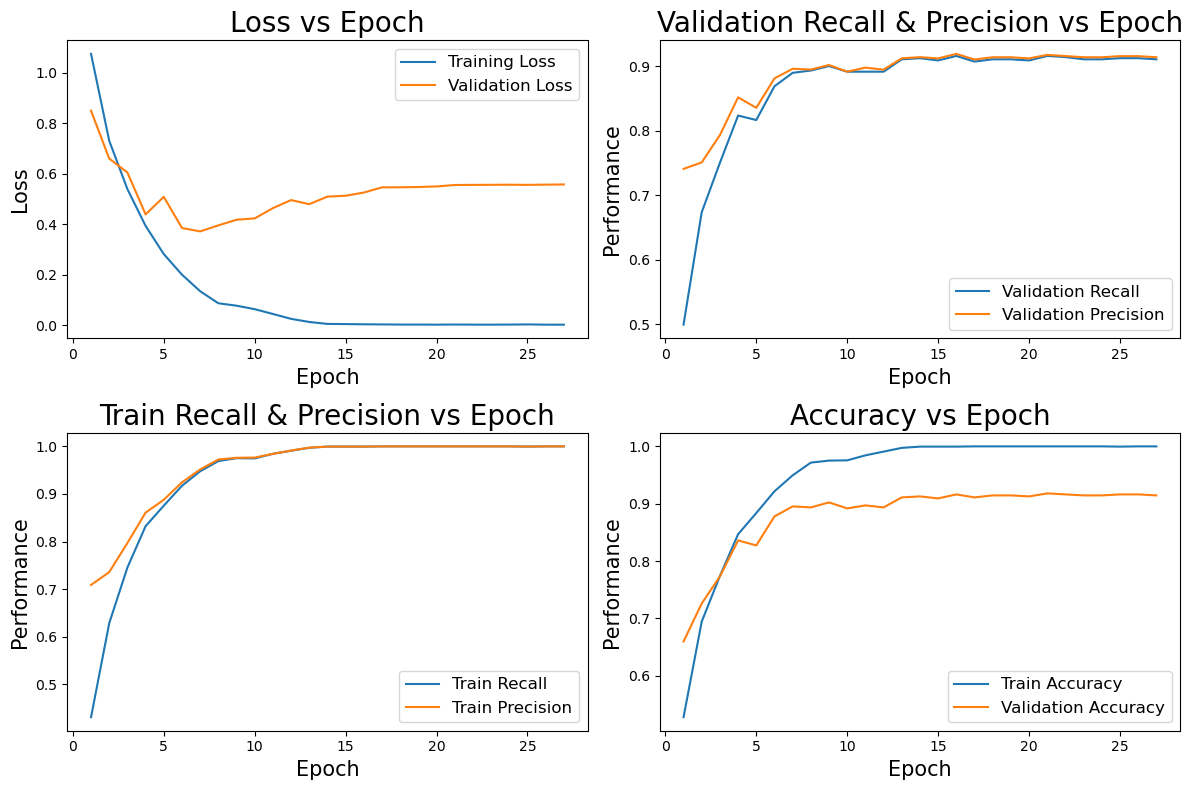

 3/13 [=====>........................] - ETA: 0s - loss: 12.5408 - precision: 0.1702 - recall: 0.1667 - accuracy: 0.1771            

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 32ms/step - loss: 0.3714 - precision: 0.8963 - recall: 0.8901 - accuracy: 0.8953


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.066638,98.429322,98.215061,98.389202
1,Test,4.091469,62.724936,61.928934,62.182742
2,Validation,0.371372,89.630932,89.005238,89.528793


In [ ]:
from functions import train_model, view_history, model_evaluate

# Train model
conv['Version3'] = train_model(cnn3, train_gen, val_gen, 100)

# View history 
view_history(conv, 'Version3')

# Evalaute model
model_evaluate(cnn3, train_gen, test_gen, val_gen)

This framework seemed to work very well. We just need to fine tune the model by doing a hyperparam search. Fine tuning will probably help with that overfit 

# Hyperparameter Tuning

In [11]:
import keras_tuner
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
from functions import get_callbacks
from keras.regularizers import l2
from tqdm import tqdm

# Create model framework
hp = keras_tuner.HyperParameters()
input_shape = (128, 128, 3)
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

def build_model(hp=hp, input_shape=input_shape, metrics=metrics):
    # Instatiate model
    model = Sequential()
    
    # Make Convolutional network
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_1', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding)_1', values=['valid', 'same']),
                    input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_2', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_2', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_1', min_value=.1, max_value=.5, step=.1)))
    model.add(Conv2D(filters=hp.Int('filters_3', min_value=16, max_value=256, step=32),
                    kernel_size=hp.Choice('kernel_size_3', values=[1, 3, 5, 10]),
                    activation='relu',
                    padding=hp.Choice('padding_3', values=['valid', 'same'])))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(hp.Float('droprate_2', min_value=.1, max_value=.5, step=.1)))
    
    # Flatten Tensor and create Fully conected layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_1', min_value=1, max_value=256, step=32), 
                    activation='relu'))
    model.add(Dropout(hp.Float('droprate_3', min_value=0, max_value=.5, step=.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=1, max_value=256, step=32), 
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('regularization_factor', min_value=1e-5, max_value=.3, sampling='log'))))
    
    # Create output layer
    model.add(Dense(units=4, activation='softmax'))
    
    # Define optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Compile model
    model.compile(optimizer=optimizer_choice,
                loss=CategoricalCrossentropy(),
                metrics=metrics)
    
    return model

# Create directory to save trail data 
tuner_directory = "trials/"

if not os.path.exists(tuner_directory):
    os.makedirs(tuner_directory)
    print(f"Directory '{tuner_directory}' created.")
else:
    print(f"Directory '{tuner_directory}' already exists.")

# Define the tuner/search strategy
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective='val_loss',
    max_epochs=8,
    directory=tuner_directory,
    project_name='my_hyperband_project',
    seed=42
)

# Tuner.search uses same param as .fit()
tuner.search(train_gen,
            epochs=50,
            validation_data=val_gen,
            callbacks=[get_callbacks()])

# Run the hyperparameter search
tuner.search(train_gen, epochs=2, validation_data=val_gen, callbacks=get_callbacks())

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model
best_model = tuner.hypermodel.build(best_hyperparameters)

Directory 'trials/' already exists.
Reloading Tuner from trials/my_hyperband_project\tuner0.json


In [12]:
# View the model
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 144)     576       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 144)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 240)       864240    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 240)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 240)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 144)       8

In [13]:
print(best_hyperparameters.values)

{'filters_1': 144, 'kernel_size_1': 1, 'padding)_1': 'same', 'filters_2': 240, 'kernel_size_2': 5, 'padding_2': 'valid', 'droprate_1': 0.5, 'filters_3': 144, 'kernel_size_3': 5, 'padding_3': 'valid', 'droprate_2': 0.30000000000000004, 'units_1': 97, 'droprate_3': 0.2, 'units_2': 161, 'regularization_factor': 0.003780517668736628, 'optimizer': 'adam', 'tuner/epochs': 8, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Epoch 1/100
72/72 [==============================] - 45s 466ms/step - loss: 1.5162 - precision: 0.5707 - recall: 0.1828 - accuracy: 0.4898 - val_loss: 1.1458 - val_precision: 0.6412 - val_recall: 0.4834 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 5s 69ms/step - loss: 0.9727 - precision: 0.7058 - recall: 0.5681 - accuracy: 0.6539 - val_loss: 0.8295 - val_precision: 0.7336 - val_recall: 0.6248 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 5s 66ms/step - loss: 0.7980 - precision: 0.7600 - recall: 0.6604 - accuracy: 0.7214 - val_loss: 0.7157 - val_precision: 0.7973 - val_recall: 0.7208 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 5s 65ms/step - loss: 0.6769 - precision: 0.7935 - recall: 0.7327 - accuracy: 0.7684 - val_loss: 0.6022 - val_precision: 0.8303 - val_recall: 0.7853 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 5/100
72/72 [==============================]

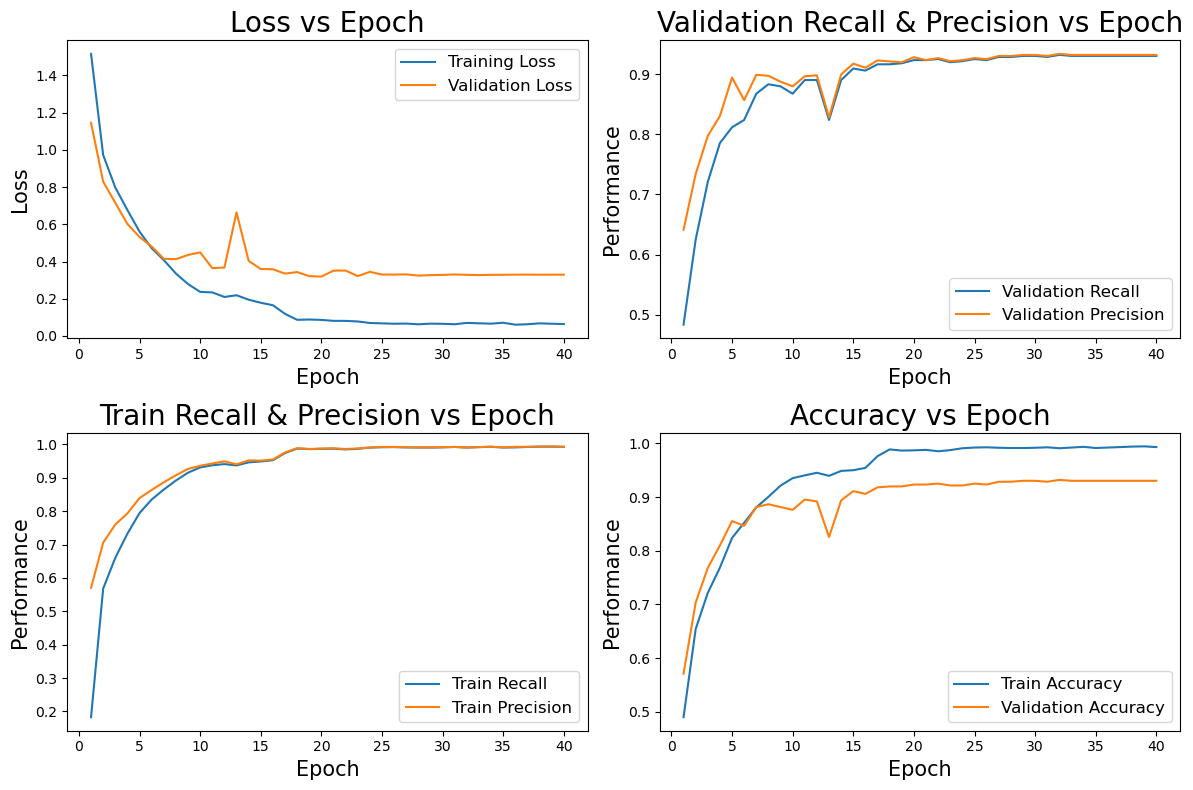

72/72 [==============================] - 2s 33ms/step - loss: 0.0516 - precision: 0.9991 - recall: 0.9987 - accuracy: 0.9987


c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 33ms/step - loss: 0.3192 - precision: 0.9281 - recall: 0.9232 - accuracy: 0.9232


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.051571,99.912894,99.869394,99.869394
1,Test,3.683594,70.725387,69.289339,70.050764
2,Validation,0.319202,92.807019,92.321116,92.321116


In [14]:
from functions import train_model, view_history, model_evaluate
conv = {}

conv['Version4'] = train_model(best_model, train_gen, val_gen, 100)

view_history(conv, 'Version4')

model_evaluate(best_model, train_gen, test_gen, val_gen)

Turns out our hyperparmater search increases performance as our val loss overall is better and so are the gaps between the model loss curves. The accuracies are not too far from eachother which is good. 

Even the test metrics are much better. We have about 10% increase on both precision and recall. 

Lets attempt data augmentation to train the already trained model 

In [15]:
from keras.models import save_model
import os 

# Specify the path 
directory = 'models/'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

print("Saved model")
# Save the model
save_model(best_model, "models/optimized.keras")

Directory 'models/' already exists.


# Data aug

In [16]:
from functions import data_augmentation
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Create data augmented generators
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_folder, test_folder, val_folder)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


Epoch 1/100
72/72 [==============================] - 10s 133ms/step - loss: 5.6970 - precision: 0.3133 - recall: 0.3056 - accuracy: 0.3148 - val_loss: 4.9832 - val_precision: 0.3315 - val_recall: 0.3211 - val_accuracy: 0.3316 - lr: 3.2000e-07
Epoch 2/100
72/72 [==============================] - 9s 124ms/step - loss: 5.7235 - precision: 0.3037 - recall: 0.2960 - accuracy: 0.3026 - val_loss: 5.3756 - val_precision: 0.3018 - val_recall: 0.2897 - val_accuracy: 0.3037 - lr: 3.2000e-07
Epoch 3/100
72/72 [==============================] - 9s 129ms/step - loss: 5.5194 - precision: 0.3336 - recall: 0.3217 - accuracy: 0.3322 - val_loss: 4.8995 - val_precision: 0.3292 - val_recall: 0.3211 - val_accuracy: 0.3264 - lr: 3.2000e-07
Epoch 4/100
72/72 [==============================] - 9s 126ms/step - loss: 5.5277 - precision: 0.3262 - recall: 0.3165 - accuracy: 0.3226 - val_loss: 4.9710 - val_precision: 0.3060 - val_recall: 0.2932 - val_accuracy: 0.3054 - lr: 3.2000e-07
Epoch 5/100
72/72 [============

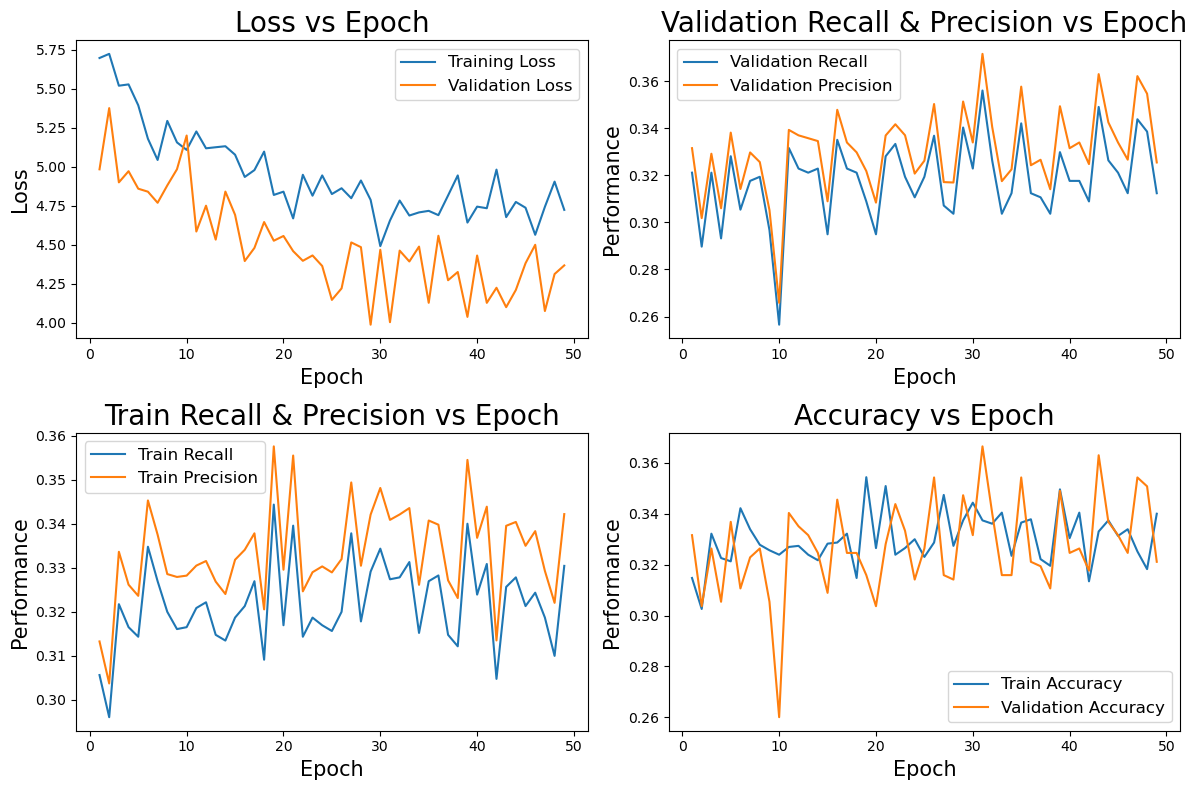

72/72 [==============================] - 7s 98ms/step - loss: 4.1856 - precision: 0.3338 - recall: 0.3191 - accuracy: 0.3335


c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 2s 96ms/step - loss: 4.3687 - precision: 0.3419 - recall: 0.3246 - accuracy: 0.3386


,Set,Loss,Precision,Recall,Accuracy
0,Train,4.185639,33.378869,31.911188,33.347845
1,Test,3.038808,70.918369,70.558375,70.558375
2,Validation,4.368702,34.191176,32.460734,33.856893


In [17]:
from functions import train_model, view_history, model_evaluate
from keras.models import load_model

# Load model
model = load_model("models/optimized.keras")

# Instantiate dictionary
aug = {}

# Train model
aug['Version1'] = train_model(model, train_gen_aug, val_gen_aug, 100)

# View training history 
view_history(aug, 'Version1')

# Evaluate model
model_evaluate(model, train_gen_aug, test_gen_aug, val_gen_aug)

We kind of see an issue here where it seems that the relu activation function caused lots of dead neurons. We know that because our Recall is terrible. Now on the bright side the test loss is so much better meaning there is better generalization. Our loss curves also look very good. 